### Logistic Regression and visualisations
To explore the relationship in the study area between variables and their spatial distribution characteristics, this study adopted the traditional logistics regression model to establish the model and evaluated the performance of the model through the residual and spatial autocorrelation test.

In [7]:
#| echo: false
# Imports  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from scipy import stats  
from statsmodels.tools import add_constant  
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import statsmodels.api as sm  
from shapely.geometry import Point  
from libpysal.weights import KNN  
from esda.moran import Moran  
from splot.esda import moran_scatterplot  
import geopandas as gpd  
from pandas.plotting import table  
import matplotlib.gridspec as gridspec  

In [8]:
#| echo: false
# Step 2: Load and preprocess data  
file_path = "processed_airbnb_data.csv"  
regression_data = pd.read_csv(file_path)  

# Select and clean columns  
columns_to_keep = [  
    "estimated_nights_booked",   
    "room_type",   
    "price",   
    "minimum_nights",  
    "calculated_host_listings_count",   
    "longitude",   
    "latitude"  
]  
regression_data = regression_data[columns_to_keep].dropna()  

# Create binary outcome for nights booked  
threshold = regression_data["estimated_nights_booked"].median()  
regression_data["estimated_nights_booked_binary"] = (  
    regression_data["estimated_nights_booked"] > threshold  
).astype(int)  

# Encode 'room_type' using OneHotEncoder  
from sklearn.preprocessing import OneHotEncoder  
encoder = OneHotEncoder(drop="first", sparse_output=False)  
room_type_encoded = encoder.fit_transform(regression_data[["room_type"]])  
room_type_columns = encoder.get_feature_names_out(["room_type"])  
room_type_df = pd.DataFrame(room_type_encoded, columns=room_type_columns, index=regression_data.index)  

# Add multi-list host column  
regression_data["multi_list_host"] = (  
    regression_data["calculated_host_listings_count"] > 1  
).astype(int)  

# Drop columns no longer needed and combine encoded features  
regression_data = regression_data.drop(columns=["calculated_host_listings_count", "room_type"])  
regression_data = pd.concat([regression_data, room_type_df], axis=1)  

In [9]:
#| echo: false  
#| output: false  
#| include: false

# Step 3: VIF Calculation  
X = regression_data.drop(  
    columns=["estimated_nights_booked", "estimated_nights_booked_binary", "longitude", "latitude"]  
)  
X = add_constant(X)  

# Calculate VIF  
vif_data = pd.DataFrame()  
vif_data["Variable"] = X.columns  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  

vif_results = vif_data  

In [15]:
#| echo: false  
#| output: false  
#| include: false
# Step 4: Run Logistic Regression  
Y = regression_data["estimated_nights_booked_binary"]  
logit_model = sm.Logit(Y, X)  
result = logit_model.fit()  

# Extract and display summary table  
regression_summary = result.summary().tables[1]  
data = regression_summary.data[1:]  # Skip the header row  
headers = regression_summary.data[0]  # Use the header  
summary_df = pd.DataFrame(data, columns=headers)  

# Add predicted probabilities and residuals  
regression_data["predicted_probs"] = result.predict(X)  
regression_data["residuals"] = (  
    regression_data["estimated_nights_booked_binary"] - regression_data["predicted_probs"]  
)  

print(result.summary())  
print("Logistic regression complete.")

Optimization terminated successfully.
         Current function value: 0.657534
         Iterations 8
                                 Logit Regression Results                                 
Dep. Variable:     estimated_nights_booked_binary   No. Observations:                43749
Model:                                      Logit   Df Residuals:                    43742
Method:                                       MLE   Df Model:                            6
Date:                            Mon, 16 Dec 2024   Pseudo R-squ.:                 0.05093
Time:                                    23:24:12   Log-Likelihood:                -28766.
converged:                                   True   LL-Null:                       -30310.
Covariance Type:                        nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [11]:
#| echo: false  
#| output: false  
#| include: false
# Step 1: Clip predicted probabilities  
regression_data["predicted_probs"] = regression_data["predicted_probs"].clip(1e-6, 1 - 1e-6)  

# Step 2: Calculate Deviance Residuals  
eps = 1e-6  # Small constant to avoid numerical issues  
regression_data["deviance_residuals"] = np.sign(  
    regression_data["estimated_nights_booked_binary"] - regression_data["predicted_probs"]  
) * np.sqrt(  
    -2 * (  
        regression_data["estimated_nights_booked_binary"] * np.log(regression_data["predicted_probs"] + eps) +  
        (1 - regression_data["estimated_nights_booked_binary"]) * np.log(1 - regression_data["predicted_probs"] + eps)  
    )  
)  

# Step 3: Convert data into GeoDataFrame  
regression_data["geometry"] = [  
    Point(xy) for xy in zip(regression_data["longitude"], regression_data["latitude"])  
]  
gdf = gpd.GeoDataFrame(regression_data, geometry="geometry", crs="EPSG:4326")  

# Step 4: Create KNN weight matrix  
weights = KNN.from_dataframe(gdf, k=3)  # k=3 means each point will connect to its 3 nearest neighbors  

# Step 5: Check for isolated points in the weight matrix  
islands = weights.islands  # Return a list of indices that are isolated/disconnected  

if len(islands) > 0:  
    print(f"Found {len(islands)} isolated points. Removing and recalculating weights...")  
    gdf_filtered = gdf.drop(islands, axis=0)  # Drop the rows corresponding to isolated points  
    weights = KNN.from_dataframe(gdf_filtered, k=3)  # Recalculate weights for the filtered dataset  
else:  
    print("No isolated points found. Continuing with the original dataset.")  
    gdf_filtered = gdf  # If no isolated points, the original dataset is used  

# Step 6: Calculate Moran's I  
moran = Moran(gdf_filtered["deviance_residuals"], weights)  

# Print Moran's I results  
print("Moran's I Results:")  
print(f"Moran's I: {moran.I:.4f}")  
print(f"p-value: {moran.p_sim:.4f}")  
print(f"z-score: {moran.z_sim:.4f}")  



/opt/conda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 322 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


No isolated points found. Continuing with the original dataset.
Moran's I Results:
Moran's I: 0.0855
p-value: 0.0010
z-score: 22.9891


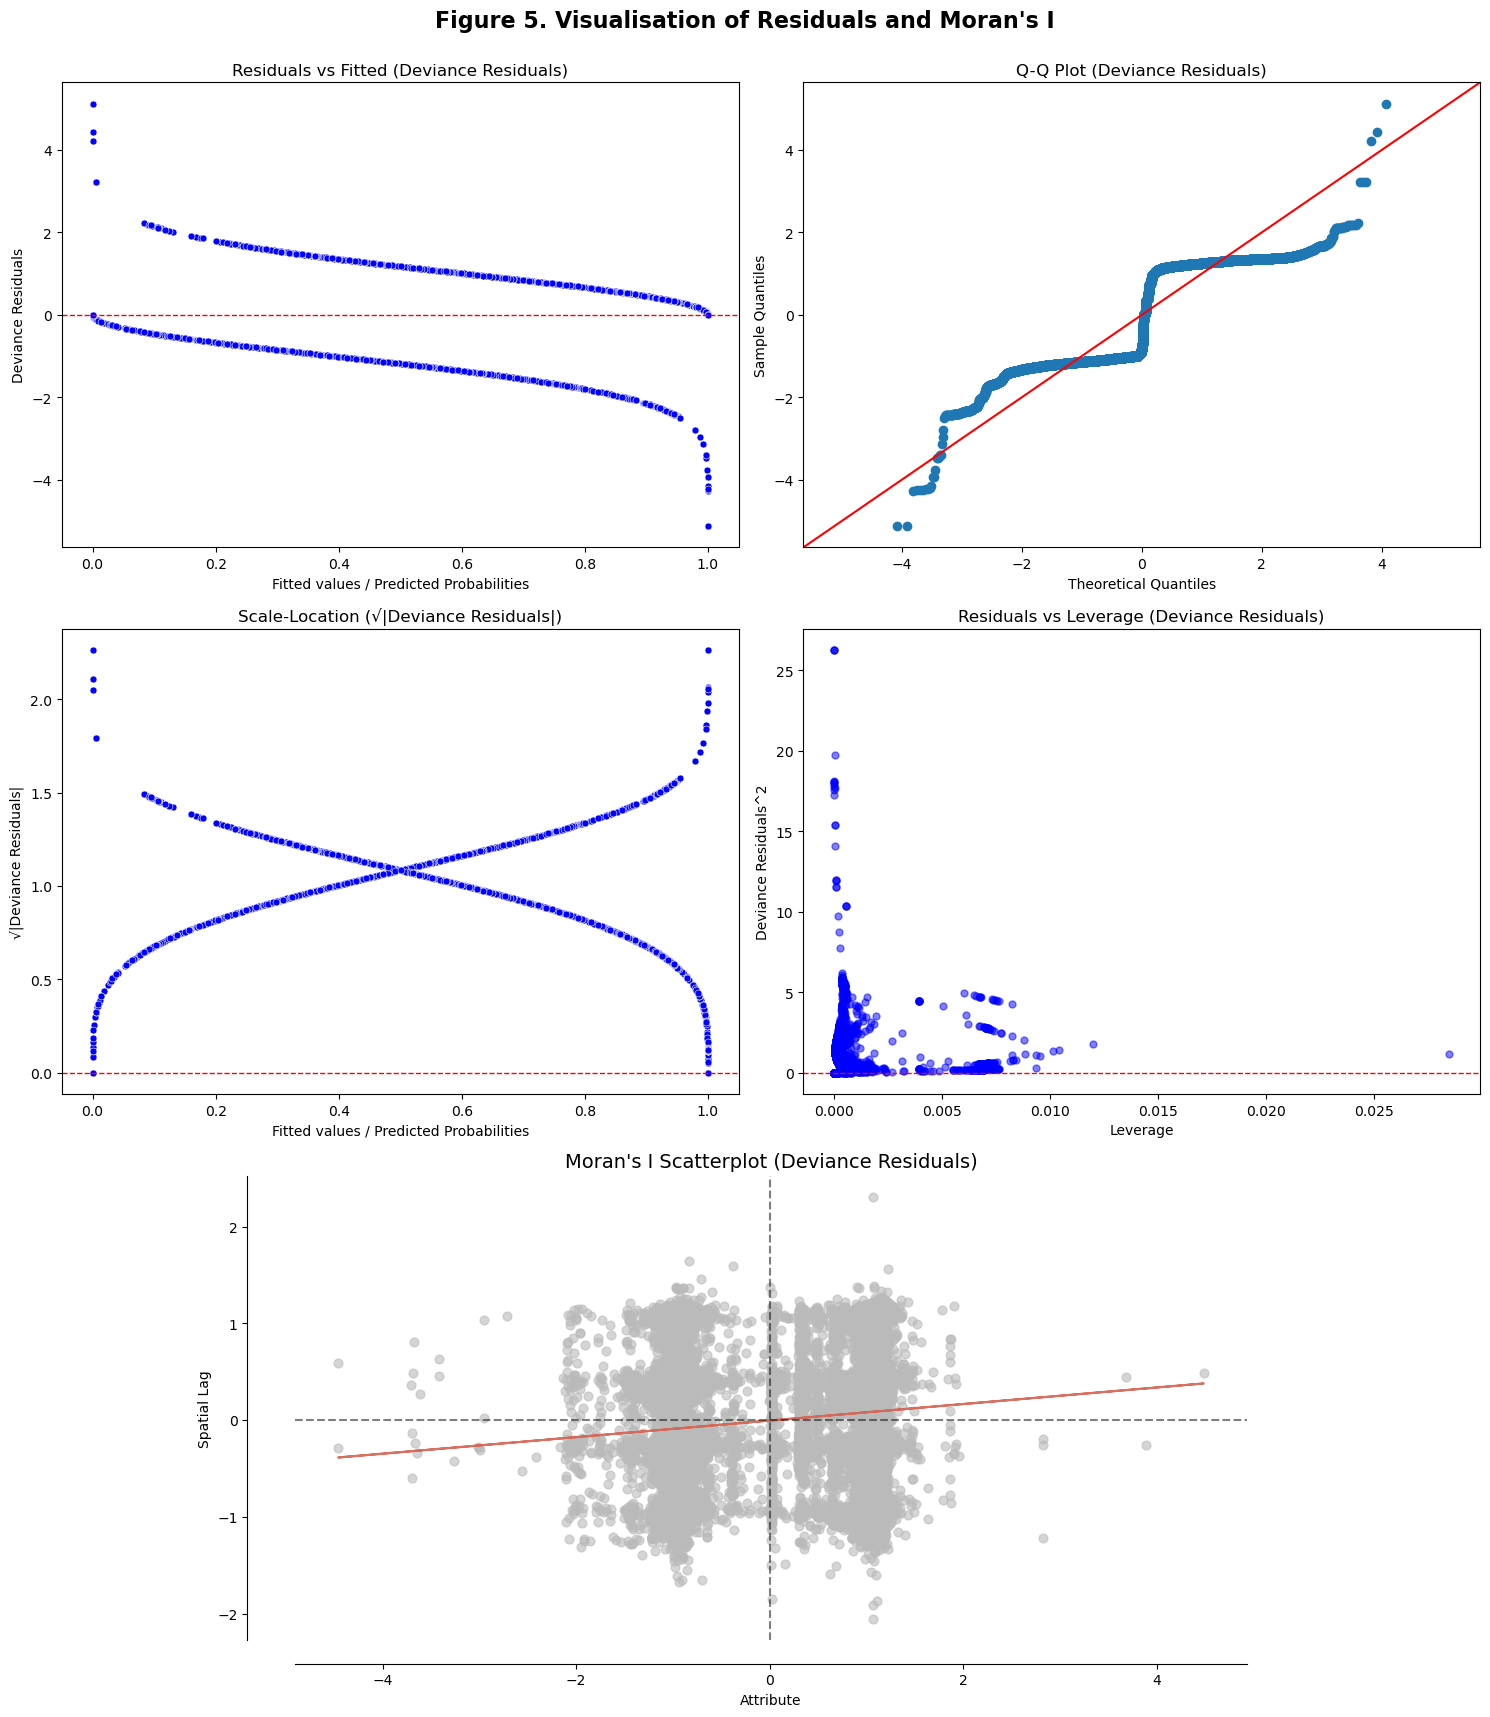

In [14]:
# Create a 3x2 subplot layout  
fig = plt.figure(figsize=(15, 18))  

# Add main title  
plt.suptitle("Figure 5. Visualisation of Residuals and Moran's I",   
             fontsize=16,   
             fontweight='bold',   
             y=0.95)  # Adjust y position of the title  

# Residuals vs Fitted Values  
ax1 = plt.subplot(3, 2, 1)  
sns.scatterplot(x=gdf_filtered["predicted_probs"], y=gdf_filtered["deviance_residuals"],  
                ax=ax1, color="blue", s=25)  
ax1.axhline(y=0, color="red", linestyle="--", linewidth=1)  
ax1.set_title("Residuals vs Fitted (Deviance Residuals)")  
ax1.set_xlabel("Fitted values / Predicted Probabilities")  
ax1.set_ylabel("Deviance Residuals")  

# Q-Q Plot  
ax2 = plt.subplot(3, 2, 2)  
sm.qqplot(gdf_filtered["deviance_residuals"], line="45", ax=ax2)  
ax2.set_title("Q-Q Plot (Deviance Residuals)")  

# Scale-Location Plot  
ax3 = plt.subplot(3, 2, 3)  
sns.scatterplot(x=gdf_filtered["predicted_probs"],   
                y=np.sqrt(np.abs(gdf_filtered["deviance_residuals"])),  
                ax=ax3, color="blue", s=25)  
ax3.axhline(y=0, color="red", linestyle="--", linewidth=1)  
ax3.set_title("Scale-Location (√|Deviance Residuals|)")  
ax3.set_xlabel("Fitted values / Predicted Probabilities")  
ax3.set_ylabel("√|Deviance Residuals|")  

# Residuals vs Leverage  
ax4 = plt.subplot(3, 2, 4)  
try:  
    influence = result.get_influence()  
    leverage = influence.hat_matrix_diag  
    deviance_residuals = gdf_filtered["deviance_residuals"]  
    
    ax4.scatter(leverage, deviance_residuals ** 2, alpha=0.5, color="blue", s=25)  
    ax4.axhline(y=0, color="red", linestyle="--", linewidth=1)  
    ax4.set_title("Residuals vs Leverage (Deviance Residuals)")  
    ax4.set_xlabel("Leverage")  
    ax4.set_ylabel("Deviance Residuals^2")  
except Exception as e:  
    print("Error during Residuals vs Leverage plotting:", e)  

# Moran's I Scatterplot  
ax5 = plt.subplot(3, 2, (5, 6))  # Span both columns in the last row  
moran_scatterplot(moran, ax=ax5)  
ax5.set_title("Moran's I Scatterplot (Deviance Residuals)", fontsize=14)  

# Adjust layout with top margin for main title  
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at top for suptitle  
plt.show()

### Result
Firstly, the VIF results show no multicollinearity issues.
The logistic regression analysis revealed significant relationships across all variables (p < 0.001) in the model with low pseudo R-squared (0.05093). 
Furthermore, the Moran's I test (Moran's I = 0.0855, p=0.0010) reveals weak but significant spatial autocorrelation, indicating spatial heterogeneity and that the model may have omitted key variables or nonlinear relationships, leading to underfitting, heteroscedasticity, and high-leverage points that require further optimization and anomaly handling. 